In [1]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

for patient in patients:

    treatment = patient.translateTreatmentLine(only = "all",
                                               mergeInactive = True,
                                               condensed = True,
                                               days = 30)

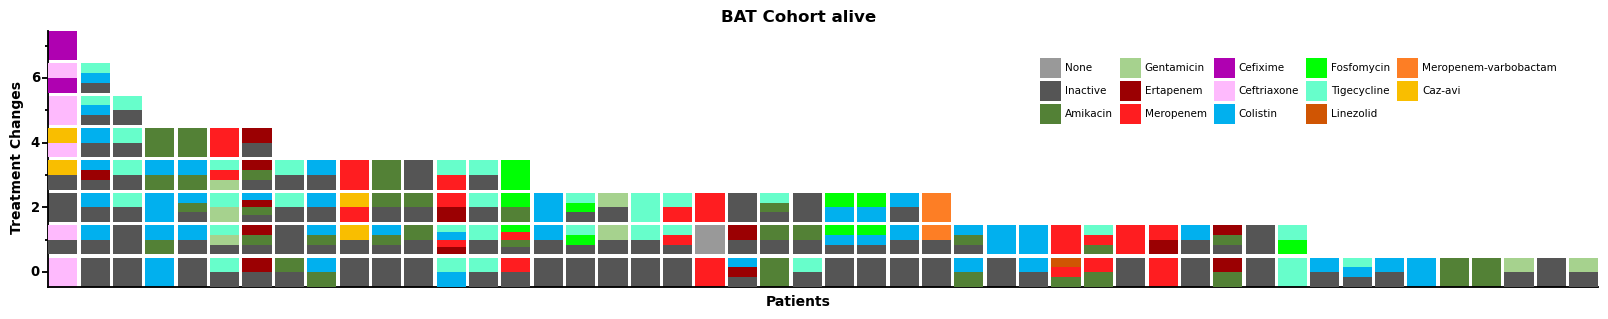

<ggplot: (8736614786675)>

In [4]:
import pandas as pd
from pystats_utils.utils.patient import Patient
from pystats_utils.utils.treatment_plot import generatePlot

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Mortality_31d"] == "no"]
data = data[data["Cohort_Cazavi"] == "no"]

patients = []
for index, row in data.iterrows():

    patient = Patient(row)

    patients.append(patient)

generatePlot(patients, days = 30, title = "BAT Cohort alive")
